Total number of parameters: 6136065
Model Size: 23.41 MB
Epoch 1, Train Loss: 2.3774, Validation Loss: 2.1259, Validation Accuracy: 0.3866, Train Time: 60.27s, Validation Time: 5.43s
Epoch 2, Train Loss: 2.0974, Validation Loss: 1.9866, Validation Accuracy: 0.4165, Train Time: 60.16s, Validation Time: 5.43s
Epoch 3, Train Loss: 1.9962, Validation Loss: 1.8962, Validation Accuracy: 0.4415, Train Time: 60.48s, Validation Time: 5.43s
Epoch 4, Train Loss: 1.9278, Validation Loss: 1.8400, Validation Accuracy: 0.4560, Train Time: 60.14s, Validation Time: 5.42s
Epoch 5, Train Loss: 1.8761, Validation Loss: 1.7962, Validation Accuracy: 0.4666, Train Time: 60.25s, Validation Time: 5.44s
Epoch 6, Train Loss: 1.8324, Validation Loss: 1.7464, Validation Accuracy: 0.4779, Train Time: 60.01s, Validation Time: 5.43s
Epoch 7, Train Loss: 1.7954, Validation Loss: 1.7094, Validation Accuracy: 0.4869, Train Time: 60.29s, Validation Time: 5.43s
Epoch 8, Train Loss: 1.7630, Validation Loss: 1.6806, Validat

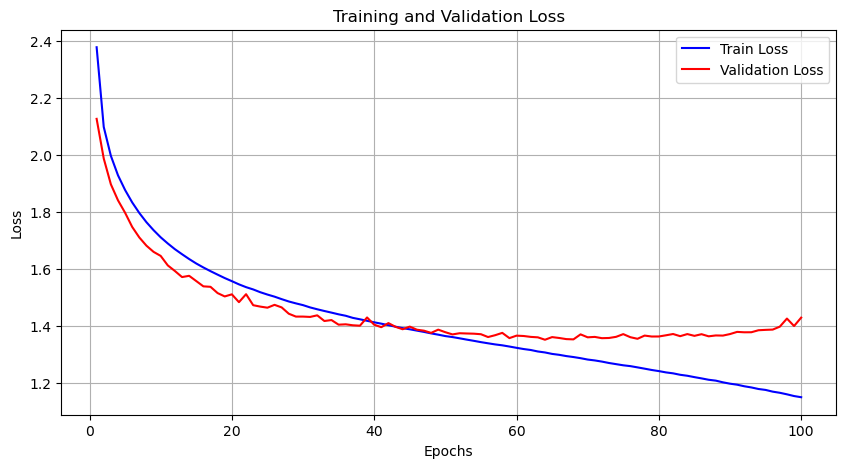

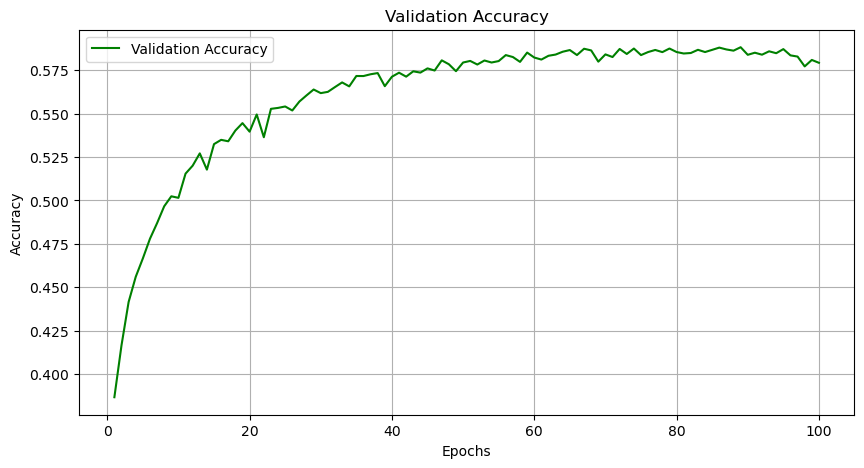

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import requests
import matplotlib.pyplot as plt
 

# Load dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  

sequence_length = 20
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

encoded_text = [char_to_int[ch] for ch in text]

sequences, targets = [], []
for i in range(len(encoded_text) - sequence_length):
    sequences.append(encoded_text[i:i + sequence_length])
    targets.append(encoded_text[i + sequence_length])

sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

dataset = CharDataset(sequences, targets)

batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout=nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output= self.dropout(output)
        output = self.fc(output[:, -1, :])  
        return output

hidden_size = 1000
learning_rate = 0.01
epochs = 100

model = CharRNN(len(chars), hidden_size, len(chars)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)  
print(f"Model Size: {model_size:.2f} MB")


train_losses, val_losses, val_accuracies = [], [], []

total_start_time = time.time()

for epoch in range(epochs):
    train_start_time = time.time()
    model.train()
    train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        val_start_time = time.time()
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            val_output = model(batch_X)
            loss = criterion(val_output, batch_y)
            val_loss += loss.item()

            _, predicted = torch.max(val_output, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct / total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_end_time = time.time()
    val_time=val_end_time - val_start_time

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Train Time: {train_time:.2f}s, Validation Time: {val_time:.2f}s")

total_end_time = time.time()
total_execution_time = total_end_time - total_start_time
print(f"Total training time (including validation): {total_execution_time:.2f} seconds")


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()
